In [ ]:
# finding single and double-positive cells

In [3]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [4]:
# dataset 2
sc1 = readRDS('Tasic_data.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
35304 features across 22375 samples within 1 assay 
Active assay: RNA (35304 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: tsne

donor_id age_days eye_condition
F2S4_160129_006_C01 227804   56       Normal       
F2S4_161028_009_B01 278251   54       Normal       
                    genotype                             driver_lines    
F2S4_160129_006_C01 Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt Snap25-IRES2-Cre
F2S4_161028_009_B01 Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt     Sst-IRES-Cre    
                    reporter_lines brain_hemisphere brain_region
F2S4_160129_006_C01 Ai14(RCL-tdT)  L                VISp        
F2S4_161028_009_B01 Ai14(RCL-tdT)  L                VISp        
                    brain_subregion injection_label_direction ⋯ tissue_type
F2S4_160129_006_C01 L6              No Injection              ⋯ tissue     
F2S4_161028_009_B01 L1-L2/3         No Injection              ⋯ tissue     
                    cell_type            assay        disease organism     sex 
F2S4_160129_006_C01 glutamatergic neuron Smart-seq v4 normal  Mus musculus male
F2S4_161028_009_B01 GABAergic neuron     Smart-seq v4 normal  Mus musculus male
                    tissue                self_reported_ethnicity
F2S4_160129_006_C01 primary visual cortex na                     
F2S4_161028_009_B01 primary visual cortex na                     
                    development_stage observation_joinid
F2S4_160129_006_C01 8-week-old stage  ;e<FNmR*F1        
F2S4_161028_009_B01 7-week-old stage  ?&<r|6#f@g

In [5]:
table(mtd1$age_days)


  51   53   54   55   56   57   58   59   63   64   66   72   77   83   84 
  40 2806 3846 3258 3580 2230 3357 2668   24   32   91   92  150  109   92 

In [6]:
table(mtd1$BICCN_subclass_label)


     Astro         CR       Endo    L2/3 IT         L4      L5 IT      L5 PT 
       556         17        166       1178       1352       2964        901 
     L6 CT      L6 IT        L6b      Lamp5 Macrophage      Meis2         NP 
      1225       2173        473       1843        131         55        740 
  No Class      Oligo       Peri      Pvalb        SMC   Serpinf1       Sncg 
       501        186         32       2076        109         85        249 
       Sst       VLMC        Vip 
      2551        133       2679 

In [7]:
table(mtd1$cell_type)


    endothelial cell            astrocyte      oligodendrocyte 
                 166                  556                  186 
  smooth muscle cell           macrophage     GABAergic neuron 
                 109                  131                 9538 
            pericyte glutamatergic neuron  leptomeningeal cell 
                  32                11023                  133 
             unknown 
                 501 

In [8]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@counts, meta.data = sc1@meta.data)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [9]:
genes = sc1@assays$RNA@meta.features$feature_name
ids = which(!is.na(genes))
exp2 = exp1[ids,]
rownames(exp2) = genes[ids]
exp2[1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
        F2S4_160129_006_C01 F2S4_161028_009_B01
Gm16259           .                     .      
Gramd1b           0.6703909            60.56084

In [10]:
sum(exp2['Neurog2',]>0)
sum(exp2['Ascl1',]>0)
sum(exp2['Neurog1',]>0)

[1] 244

[1] 4206

[1] 77

In [11]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [12]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp2, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp2, 'Neurog2', 'Neurog1')

In [13]:
# save file
saveids = which(exp2['Neurog2',]>0 | exp2['Ascl1',]>0 | exp2['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp2[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Tasic_A1N1N2.rds')

[1] 4460

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
70608 features across 4460 samples within 1 assay 
Active assay: RNA (70608 features, 0 variable features)
 2 layers present: counts, data

In [10]:
gene1_exp = exp2['Neurog2',]
gene2_exp = exp2['Neurog1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [18]:
cor(vec1, vec2, method = 'spearman')

[1] 0.01234383

In [19]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp m1_rank   m2_rank  
F2S4_160129_006_C01 0      0      0.4945698 0.4060335
F2S4_161028_009_B01 0      0      0.4945698 0.4060335

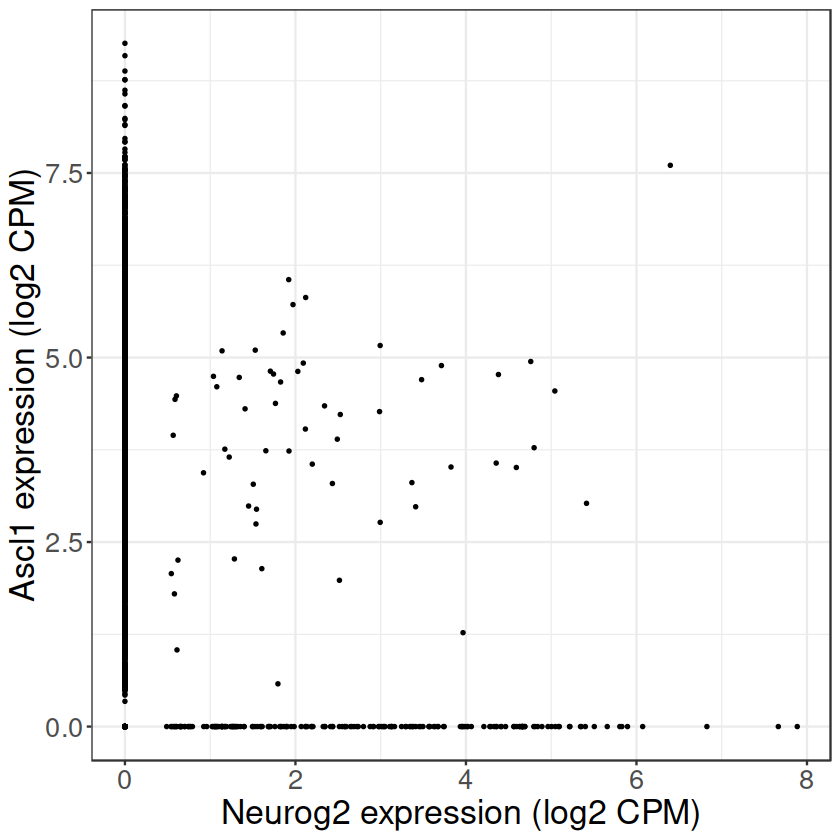

In [20]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

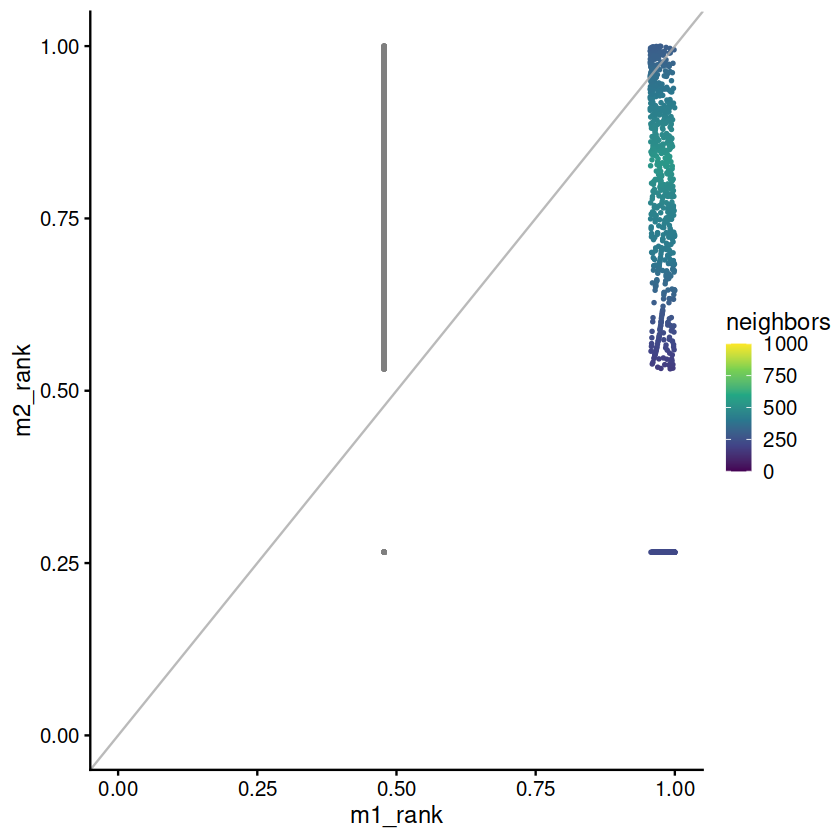

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [11]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 2

[1] 242

[1] 75

In [22]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$cell_type[id1]))


           astrocyte     GABAergic neuron glutamatergic neuron 
                   1                    1                   54 
             unknown 
                   3 

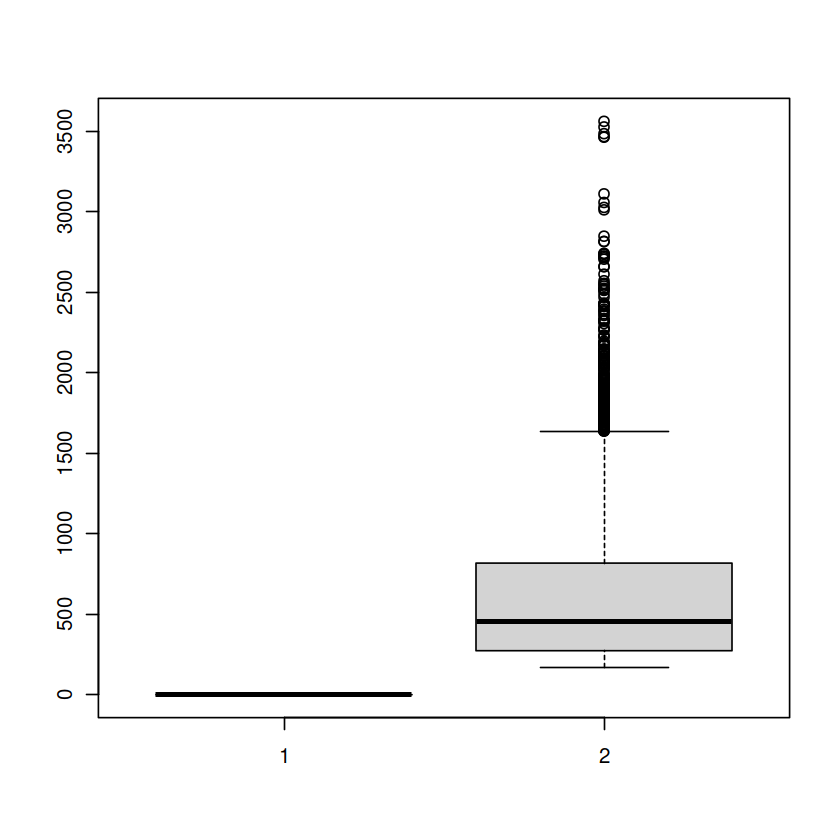

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [23]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Pax6"

[1] 4178

[1] 10

[1] 45

[1] 796

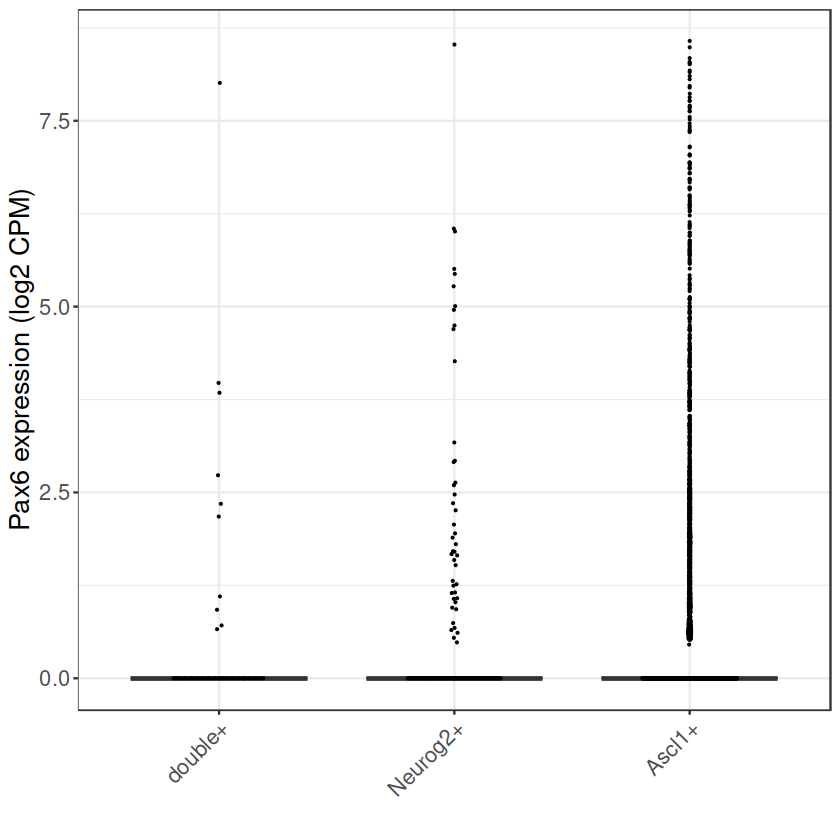

In [24]:
# other coexpressing genes
currgene = 'Pax6'
currgene
sum(exp2[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp2[currgene, id1]>0)
sum(exp2[currgene, id2]>0)
sum(exp2[currgene, id3]>0)

exp_vec = exp2[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [12]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp2), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp2[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp2)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 35302

[1] 5256

In [13]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp2[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 1525

gene  dbl_exp  gene1_exp gene2_exp retain
1 Grm3  8.388773 4.024683  5.297790  1     
2 Rasa2 8.368384 4.382863  5.557605  1

In [14]:
dfnew$gene[dfnew$retain==1]

[1] "Grm3"                             "Rasa2"                           
   [3] "Tapt1"                            "Fbh1"                            
   [5] "Calu"                             "Flcn"                            
   [7] "Mau2"                             "Marchf6"                         
   [9] "Pdk2"                             "Clpx"                            
  [11] "Ap3m1"                            "Klhl24"                          
  [13] "Ncan"                             "Wdr26"                           
  [15] "Diablo"                           "Coro1b"                          
  [17] "Pank4"                            "Washc4"                          
  [19] "Tdp2"                             "Hdhd5"                           
  [21] "Fads1"                            "Rb1"                             
  [23] "Tmem62"                           "Slc20a2"                         
  [25] "Zfp60"                            "Atxn7"                           
  [27] "Hdlbp"                            "Tmem209"                         
  [29] "Vcl"                              "Prkcsh"                          
  [31] "Slc4a3"                           "Zfp512"                          
  [33] "Pttg1ip"                          "Csdc2"                           
  [35] "Tmem165"                          "Ptprt"                           
  [37] "Osbpl2"                           "Uso1"                            
  [39] "D5Ertd579e"                       "Fam13c"                          
  [41] "Fam184a"                          "Tjp1"                            
  [43] "Ddit4l"                           "Ddx39a"                          
  [45] "2310057M21Rik"                    "Washc5"                          
  [47] "Vcpip1"                           "Rundc1"                          
  [49] "Ampd2"                            "Usp54"                           
  [51] "Fhl1"                             "Abcd3"                           
  [53] "Rasa1"                            "Acbd5"                           
  [55] "Chpt1"                            "Chmp1b"                          
  [57] "Abcb9"                            "Ankhd1"                          
  [59] "Mars1"                            "Egln2"                           
  [61] "Orc2"                             "Rnft1"                           
  [63] "Amer2"                            "Aifm3"                           
  [65] "Fryl"                             "Zfp397"                          
  [67] "Rskr"                             "Tm9sf1"                          
  [69] "Fubp3"                            "Enah"                            
  [71] "Zfp866"                           "Akt2"                            
  [73] "Usp19"                            "Chst2"                           
  [75] "Pomt2"                            "Fam91a1"                         
  [77] "Tmem25"                           "Ubac2"                           
  [79] "Zmpste24"                         "Adcy9"                           
  [81] "Usp38"                            "Med17"                           
  [83] "Fig4"                             "Ppp3cc"                          
  [85] "Rpa1"                             "Brd2"                            
  [87] "Bmp1"                             "Armcx5"                          
  [89] "Slitrk5"                          "Usp25"                           
  [91] "Dnajc11"                          "Abcd2"                           
  [93] "Ints8"                            "Ccdc50"                          
  [95] "Tmem167b"                         "Herpud2"                         
  [97] "Cep83os"                          "Eif4b"                           
  [99] "Ginm1"                            "Acad9"                           
 [101] "Vps33b"                           "Endod1"                          
 [103] "Vhl"                              "Rnf19a"                          

In [15]:
# df for saving
write.table(dfnew, file = 'tasic_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

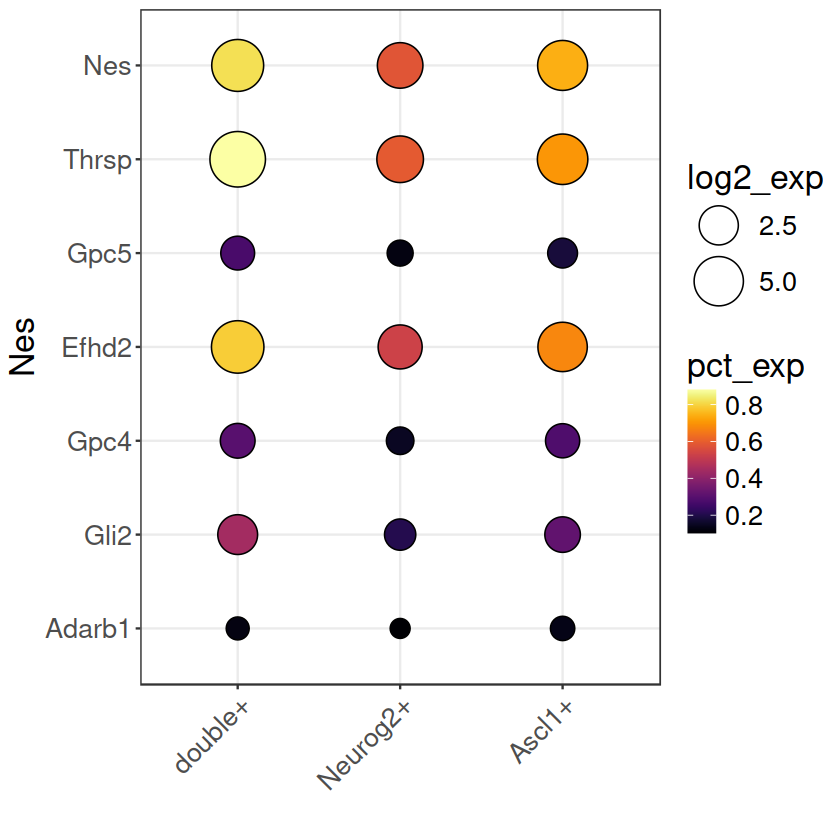

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()